# Fitting to residue burial data
Using data from: *Wheat Debris as an Inoculum Source for Seedling Infection by Septoria tritici, Brokenshire, 1975*

And *Relative importance of different types of inoculum to the  establishment of Mycosphaerella graminicola in wheat  crops in north-west Europe, Suffert and Sache, 2011*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
import pandas as pd

# For simulation
from Functions_base import ic_twofield, t_growing

# For ODEs
from Functions_base import beta_base, Temerge, gamma, g_1D, sigma, mu, v, T69,T75

# For plotting
from Functions_base import G, Temerge, T87
from Functions_plotting import c1,c2,c3,c4,c5,plot_one_intervention
import matplotlib as mpl
my_col = mpl.colors.LinearSegmentedColormap.from_list('my_col',[c1,c2,c3,c4,c5])

In [2]:
# Disease system
def dPop(ic,t,epi_severity):
    
    beta = beta_base*epi_severity
    
    S_M,E_M,I_M,R_M,D_M,P_M = ic[:6]
    S_N,E_N,I_N,R_N,D_N,P_N = ic[6:]
    
    A_M = S_M + E_M + I_M + R_M + D_M
    A_N = S_N + E_N + I_N + R_N + D_N
    
    # Residue management
    if t > Temerge:
        FOL = gamma*E_M
            
        # Set transmission rate
        FOI = beta*(I_M + P_M)

        dS_M = g_1D(A_M,t) - sigma(t)*S_M - (S_M/A_M)*FOI
        dE_M = (S_M/A_M)*FOI - sigma(t)*E_M - FOL
        dI_M = FOL - mu*I_M
        dR_M = sigma(t)*(S_M+E_M)
        dD_M = mu*I_M
        dP_M = -v*P_M
        
    else:
        dS_M = 0
        dE_M = 0
        dI_M = 0
        dR_M = 0
        dD_M = 0
        dP_M = 0

    # Uncontrolled fields
    if t > Temerge:
        
        # Set uncontrolled FOI
        FOI = beta*(I_N + P_N)
        
        dS_N = g_1D(A_N,t) - sigma(t)*S_N - (S_N/A_N)*FOI
        dE_N = (S_N/A_N)*FOI - sigma(t)*E_N - gamma*E_N
        dI_N = gamma*E_N - mu*I_N
        dR_N = sigma(t)*(S_N+E_N)
        dD_N = mu*I_N
        dP_N = -v*P_N
        
    else:
        dS_N = 0
        dE_N = 0
        dI_N = 0
        dR_N = 0
        dD_N = 0
        dP_N = 0

    return [dS_M,dE_M,dI_M,dR_M,dD_M,dP_M, dS_N,dE_N,dI_N,dR_N,dD_N,dP_N]

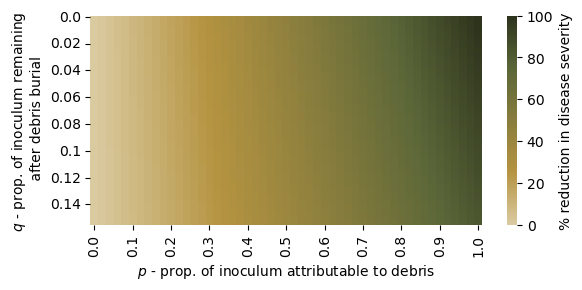

In [3]:
# Run with modified initial conditions

# Time values, taken from Hobbelen time data
idx_6975 = slice(T69-Temerge, T75-Temerge,1)
t_6975 = t_growing[idx_6975]

# Run over all (applicable) pairs of (p,q)
# p - proportion ascospores from within-field debris
# q - proportion ascospores remaining after debris clearing
interval = 0.002
all_p = np.arange(0,1.002,0.02) # All possible values of p
all_q = np.arange(0,0.1/0.65+interval,interval) # Values of q taken from Brokenshire 1975

# Matrix for saving disease reduction values
save_red = np.zeros((len(all_p),len(all_q)))

# Iterate through values of q and p
for j in range(len(all_q)):
    q = all_q[j]
    
    for i in range(len(all_p)):
        p = all_p[i]

        # Reduce the initial conditions according to the proportion from residue, and the amount of residue removed
        ic = 1*ic_twofield
        ic[5] = p*q*ic[5] + (1-p)*ic[5]
        pop = odeint(func = dPop, y0 = ic, t = t_growing, args = (1,))

        # Clip at assessment period
        pop = pop[idx_6975,:]

        # Get IPM values
        pop_ipm = pop[:,:5]
        tot_ipm = np.sum(pop_ipm, axis = 1)
        I_ipm = pop_ipm[:,2]

        # Get no control values
        pop_nocontrol = pop[:,6:-1]
        tot_nocontrol = np.sum(pop_nocontrol, axis = 1)
        I_nocontrol = pop_nocontrol[:,2]

        # Compute infection prevalence
        prop_ipm = np.trapz(t_6975,I_ipm/tot_ipm)
        prop_nocontrol = np.trapz(t_6975,I_nocontrol/tot_nocontrol)
        save_red[i,j] = 100 - 100*prop_ipm/prop_nocontrol

# SI heatmap of disease severity for pairs of (p,q)
import seaborn as sns

fig,ax = plt.subplots(1,figsize=(6,3))
sns.heatmap(save_red.T,cmap=my_col,ax=ax,cbar_kws={'label': '% reduction in disease severity'})

ax.set_ylabel("$q$ - prop. of inoculum remaining \n after debris burial")
ax.set_xlabel("$p$ - prop. of inoculum attributable to debris")
ax.set_yticks(ticks = np.arange(0,len(all_q),10)+0.5, labels = np.around(all_q[::10],3))
ax.set_xticks(ticks = np.arange(0,len(all_p),5)+0.5, labels = np.around(all_p[::5],2))
plt.tight_layout()

# Save figure
fig.savefig('Figures/Manuscript_final/fig_inoculumheatmap.pdf', dpi=400)

In [4]:
# Find range of p for each fixed value of q
# Values of q taken from Brokenshire 1975
# Values of p fitted up to 75% reduction in severity (Suffert and Sache, 2011)

# Resolution: 3dp
interval = 0.001

# Iterate over values of q and p
for q in np.arange(0,0.1/0.65+interval,interval):
    percent_red = 0
    p = 0.67
    
    while percent_red < 75 and round(p,5) <= 1:
        p += 0.0005

        # Reduce the initial conditions according to the proportion from residue, and the amount of residue removed
        ic = 1*ic_twofield
        ic[5] = p*q*ic[5] + (1-p)*ic[5]
        pop = odeint(func = dPop, y0 = ic, t = t_growing, args = (1,))

        # Clip at assessment period
        pop = pop[idx_6975,:]

        # Get IPM values
        pop_ipm = pop[:,:5]
        tot_ipm = np.sum(pop_ipm, axis = 1)
        I_ipm = pop_ipm[:,2]

        # Get no control values
        pop_nocontrol = pop[:,6:-1]
        tot_nocontrol = np.sum(pop_nocontrol, axis = 1)
        I_nocontrol = pop_nocontrol[:,2]

        # Need to 
        prop_ipm = np.trapz(t_6975,I_ipm/tot_ipm)
        prop_nocontrol = np.trapz(t_6975,I_nocontrol/tot_nocontrol)

        percent_red = (100 - 100*prop_ipm/prop_nocontrol)
    p -= 0.0005
    
    print("q = " + str(round(q,4)) + " , p = " + str(round(p,4)))
    print("Disease severity reduction of " + str(round(100 - 100*prop_ipm/prop_nocontrol,4)) + "%")
    print("")

q = 0.0 , p = 0.7765
Disease severity reduction of 75.0477%

q = 0.001 , p = 0.777
Disease severity reduction of 75.0177%

q = 0.002 , p = 0.778
Disease severity reduction of 75.0415%

q = 0.003 , p = 0.7785
Disease severity reduction of 75.0112%

q = 0.004 , p = 0.7795
Disease severity reduction of 75.0347%

q = 0.005 , p = 0.78
Disease severity reduction of 75.0042%

q = 0.006 , p = 0.781
Disease severity reduction of 75.0272%

q = 0.007 , p = 0.782
Disease severity reduction of 75.0501%

q = 0.008 , p = 0.7825
Disease severity reduction of 75.0191%

q = 0.009 , p = 0.7835
Disease severity reduction of 75.0416%

q = 0.01 , p = 0.784
Disease severity reduction of 75.0104%

q = 0.011 , p = 0.785
Disease severity reduction of 75.0325%

q = 0.012 , p = 0.7855
Disease severity reduction of 75.001%

q = 0.013 , p = 0.7865
Disease severity reduction of 75.0227%

q = 0.014 , p = 0.7875
Disease severity reduction of 75.0442%

q = 0.015 , p = 0.788
Disease severity reduction of 75.0123%

q = 0

q = 0.132 , p = 0.8945
Disease severity reduction of 75.0325%

q = 0.133 , p = 0.8955
Disease severity reduction of 75.0295%

q = 0.134 , p = 0.8965
Disease severity reduction of 75.0263%

q = 0.135 , p = 0.8975
Disease severity reduction of 75.0228%

q = 0.136 , p = 0.8985
Disease severity reduction of 75.0191%

q = 0.137 , p = 0.8995
Disease severity reduction of 75.0152%

q = 0.138 , p = 0.9005
Disease severity reduction of 75.0111%

q = 0.139 , p = 0.9015
Disease severity reduction of 75.0068%

q = 0.14 , p = 0.9025
Disease severity reduction of 75.0023%

q = 0.141 , p = 0.904
Disease severity reduction of 75.044%

q = 0.142 , p = 0.905
Disease severity reduction of 75.0389%

q = 0.143 , p = 0.906
Disease severity reduction of 75.0337%

q = 0.144 , p = 0.907
Disease severity reduction of 75.0282%

q = 0.145 , p = 0.908
Disease severity reduction of 75.0225%

q = 0.146 , p = 0.909
Disease severity reduction of 75.0166%

q = 0.147 , p = 0.91
Disease severity reduction of 75.0105%

q 

In [5]:
# Run worst-case scenario
p = 0
q = 0
ic = 1*ic_twofield
ic[5] = p*q*ic[5] + (1-p)*ic[5]
pop0 = odeint(func = dPop, y0 = ic, t = t_growing, args = (1,))

# Run default scenario
p = 0.1
q = 0.154
ic = 1*ic_twofield
ic[5] = p*q*ic[5] + (1-p)*ic[5]
pop1 = odeint(func = dPop, y0 = ic, t = t_growing, args = (1,))

# Run best-case scenario
p = 0.777
q = 0
ic = 1*ic_twofield
ic[5] = p*q*ic[5] + (1-p)*ic[5]
pop2 = odeint(func = dPop, y0 = ic, t = t_growing, args = (1,))

Yields
[0.9003283189830485, 0.9070771997124738, 0.9730628233901871]
Peak percent infection
[0.13976574484516038, 0.1324146253588587, 0.045179681341101056]


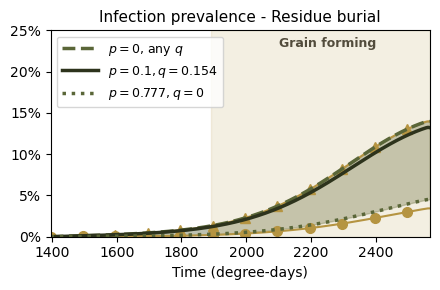

In [6]:
# Run imported plotting function
fig,ax = plot_one_intervention([pop2[:,:6],pop1[:,:6],pop0[:,:6]][::-1],[r"$p=0.777,q=0$",r"$p=0.1,q=0.154$",r"$p=0$, any $q$"][::-1],"Residue burial")
plt.tight_layout()
# Save figure
fig.savefig('Figures/Manuscript_final/fig_1control_residueremoval.pdf', dpi=400)